# Backtesting a Strategy Based on Simple Moving Average

In [39]:
import backtrader as bt
from datetime import datetime
import pandas as pd
import yfinance as yf

1- Define a class representing the trading strategy

In [40]:
class smaSignal(bt.Signal):
    params = (('period', 20), )

    def __init__(self):
        self.lines.signal = self.data - bt.ind.SMA(period=self.p.period)

2- Download data from Yahoo Finance

In [41]:
data = bt.feeds.PandasData(dataname=yf.download("AMZN", start="2020-01-01", end="2020-12-31"))

[*********************100%%**********************]  1 of 1 completed


3- Set up the backtest

In [42]:
cerebro = bt.Cerebro(stdstats=False)

cerebro.adddata(data)
cerebro.broker.setcash(1000.0)
cerebro.add_signal(bt.SIGNAL_LONG, smaSignal)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)

4- Run the backtest

In [43]:
print(f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}')
cerebro.run()
print(f'Final Portfolio Value: {cerebro.broker.getvalue():.2f}')

Starting Portfolio Value: 1000.00
Final Portfolio Value: 1016.78


5- Plot the results

<IPython.core.display.Javascript object>


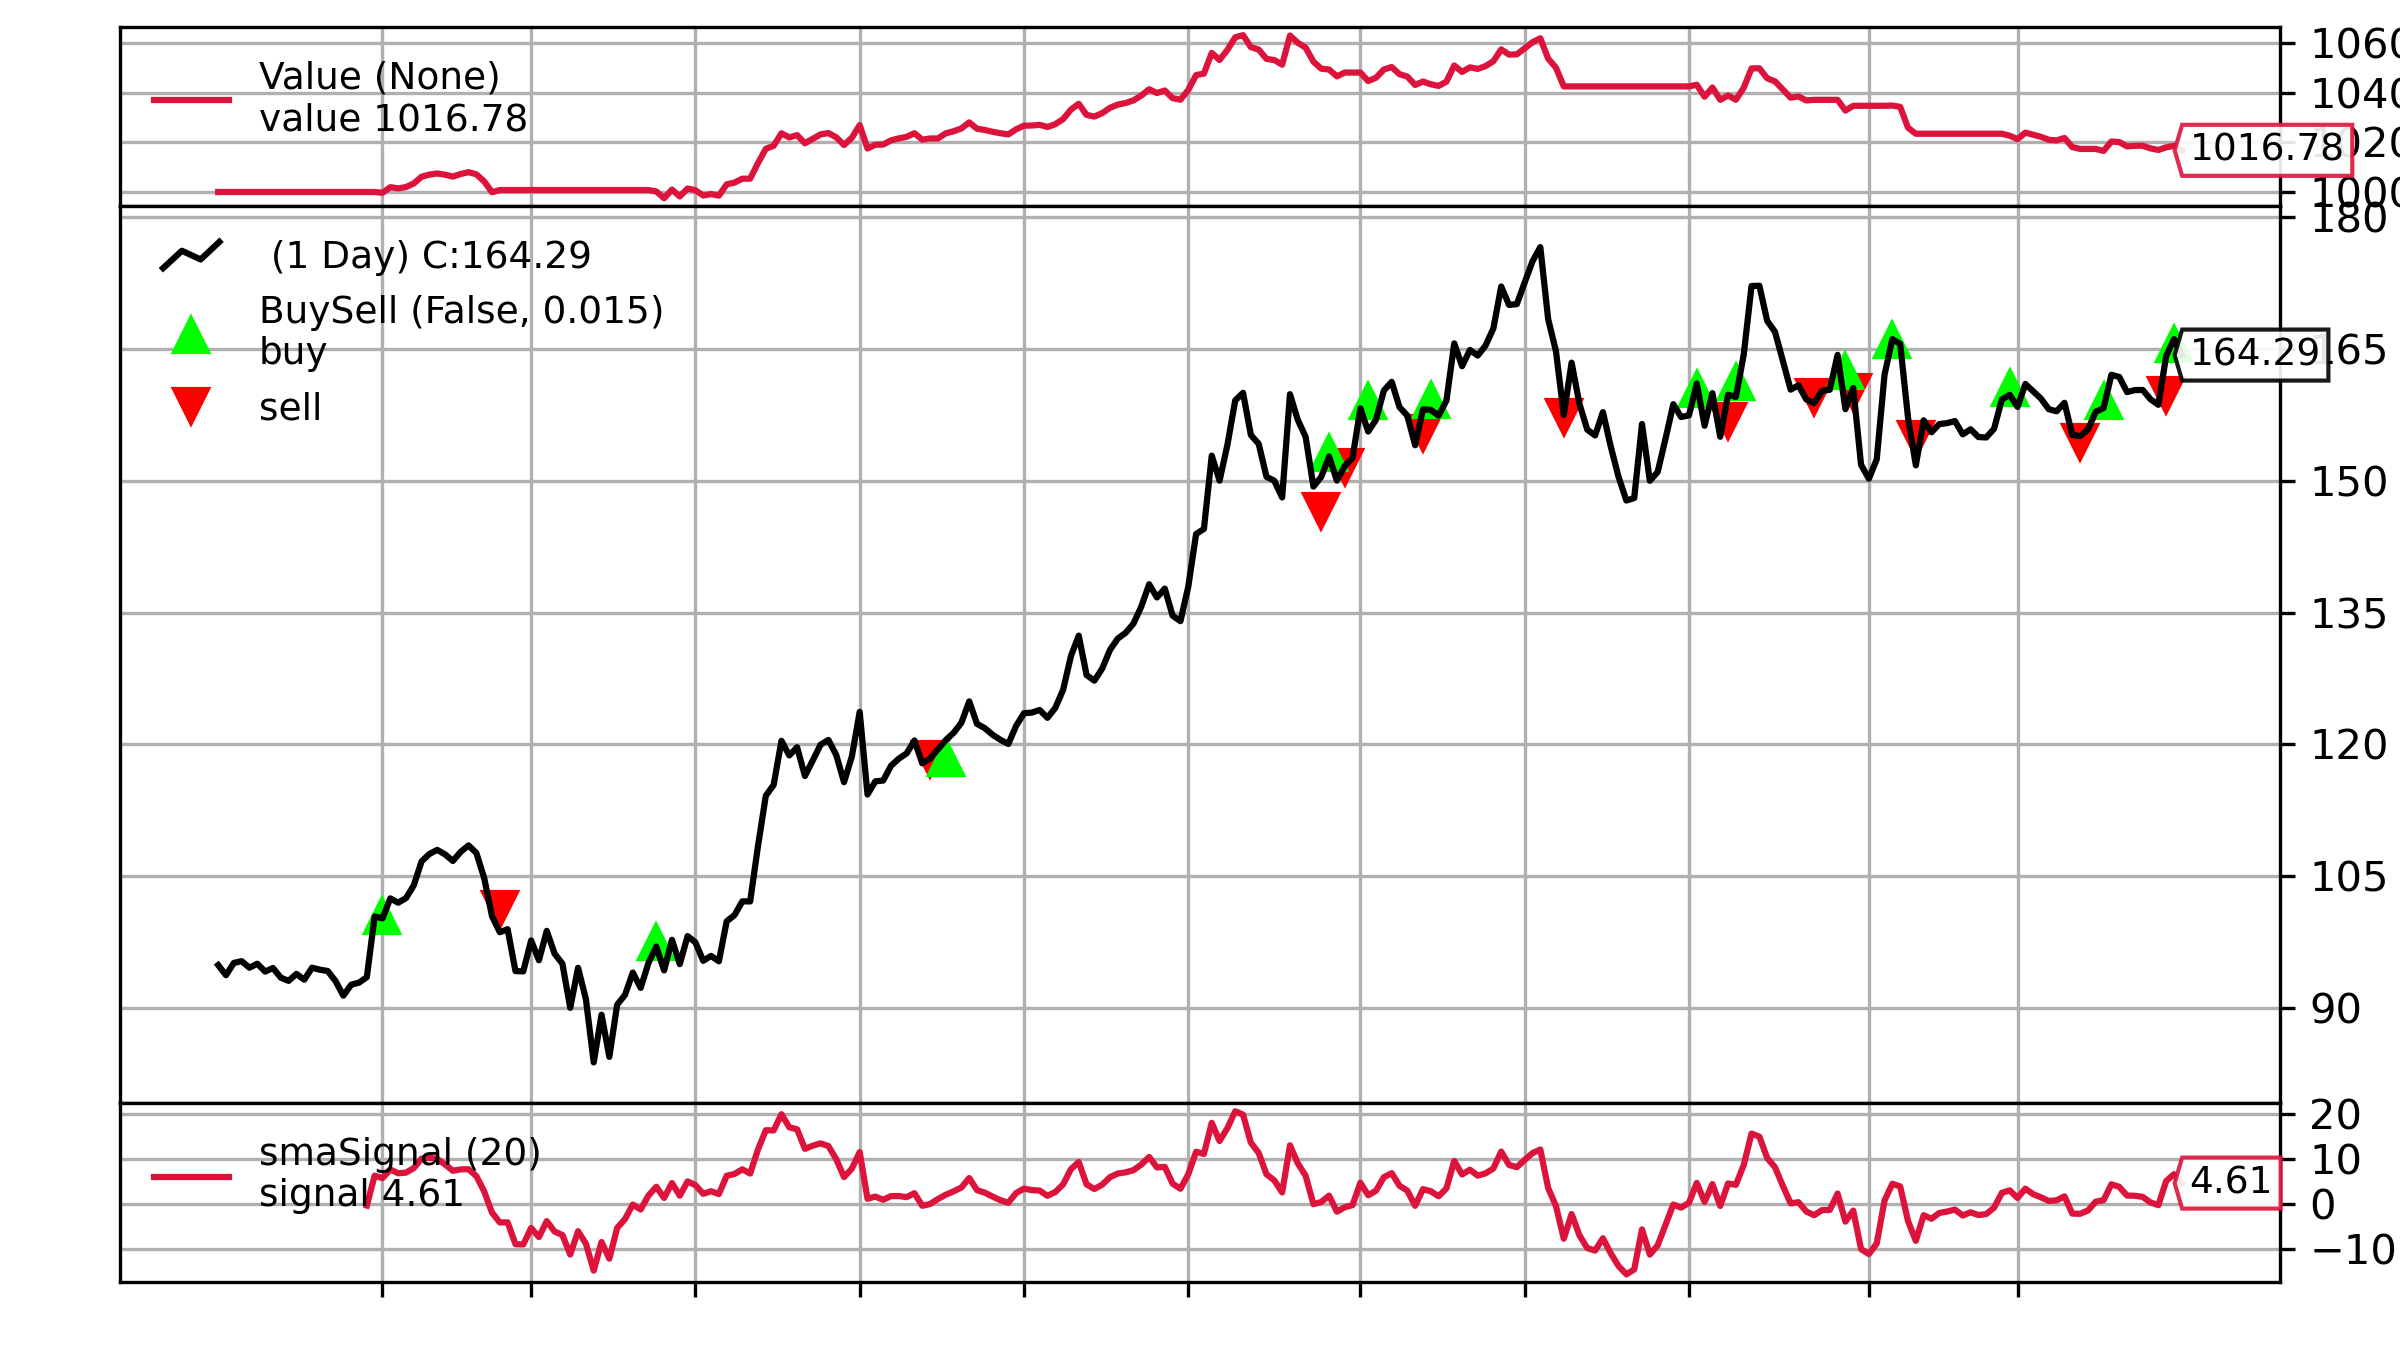

[[<Figure size 2400x1350 with 3 Axes>]]

In [45]:
cerebro.plot(iplot=True, volume=False)

## Strategy

1- The template of the strategy looks like

In [49]:
class SmaStrategy(bt.Strategy):
    params = (('ma_period', 20), )
    
    def __init__(self):
        # keep track of close price in the series
        self.data_close = self.datas[0].close
        
        # keep track of pending orders/buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None
        
        # add a simple moving average indicator
        self.sma = bt.ind.SMA(self.datas[0],
                             period=self.params.ma_period)
        
    def log(self, txt):
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return
        
        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}')
                self.price = order.executed.price
                self.comm = order.executed.comm
        # report failed order
        elif order.status in [order.Canceled, order.Margin, 
                             order.Rejected]:
            self.log('Order Failed')
        # set no pending order
        self.order = None
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        
        self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')
        
    def next(self):
        # do nothing if an order is pending
        if self.order:
            return
        
        # check if there is already a position
        if not self.position:
            # buy condition
            if self.data_close[0] > self.sma[0]:
                self.log(f'BUY CREATED --- Price: {self.data_close[0]:.2f}')
                self.order = self.buy()
                
        else:
            # sell condition
            if self.data_close[0] < self.sma[0]:            
                self.log(f'SELL CREATED --- Price: {self.data_close[0]:.2f}')
                self.order = self.sell()

2- Set up the backtest

In [50]:
cerebro = bt.Cerebro(stdstats=False)

cerebro.adddata(data)
cerebro.broker.setcash(5000.0)
cerebro.addstrategy(SmaStrategy)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)

3- Run the backtest

In [51]:
print(f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}')
cerebro.run()
print(f'Final Portfolio Value: {cerebro.broker.getvalue():.2f}')

Starting Portfolio Value: 5000.00
2020-01-31, BUY CREATED --- Price: 100.44
2020-02-03, BUY EXECUTED --- Price: 100.53, Cost: 100.53, Commission: 0.00
2020-02-24, SELL CREATED --- Price: 100.46
2020-02-25, OPERATION RESULT --- Gross: 0.79, Net: 0.79
2020-03-23, BUY CREATED --- Price: 95.14
2020-03-24, BUY EXECUTED --- Price: 97.57, Cost: 97.57, Commission: 0.00
2020-05-12, SELL CREATED --- Price: 117.85
2020-05-13, OPERATION RESULT --- Gross: 20.76, Net: 20.76
2020-05-14, BUY CREATED --- Price: 119.44
2020-05-15, BUY EXECUTED --- Price: 118.43, Cost: 118.43, Commission: 0.00
2020-07-23, SELL CREATED --- Price: 149.33
2020-07-24, OPERATION RESULT --- Gross: 28.07, Net: 28.07
2020-07-24, BUY CREATED --- Price: 150.45
2020-07-27, BUY EXECUTED --- Price: 153.10, Cost: 153.10, Commission: 0.00
2020-07-28, SELL CREATED --- Price: 150.02
2020-07-29, OPERATION RESULT --- Gross: -1.55, Net: -1.55
2020-07-31, BUY CREATED --- Price: 158.23
2020-08-03, BUY EXECUTED --- Price: 159.03, Cost: 159.03,

4- Plot the result:

<IPython.core.display.Javascript object>


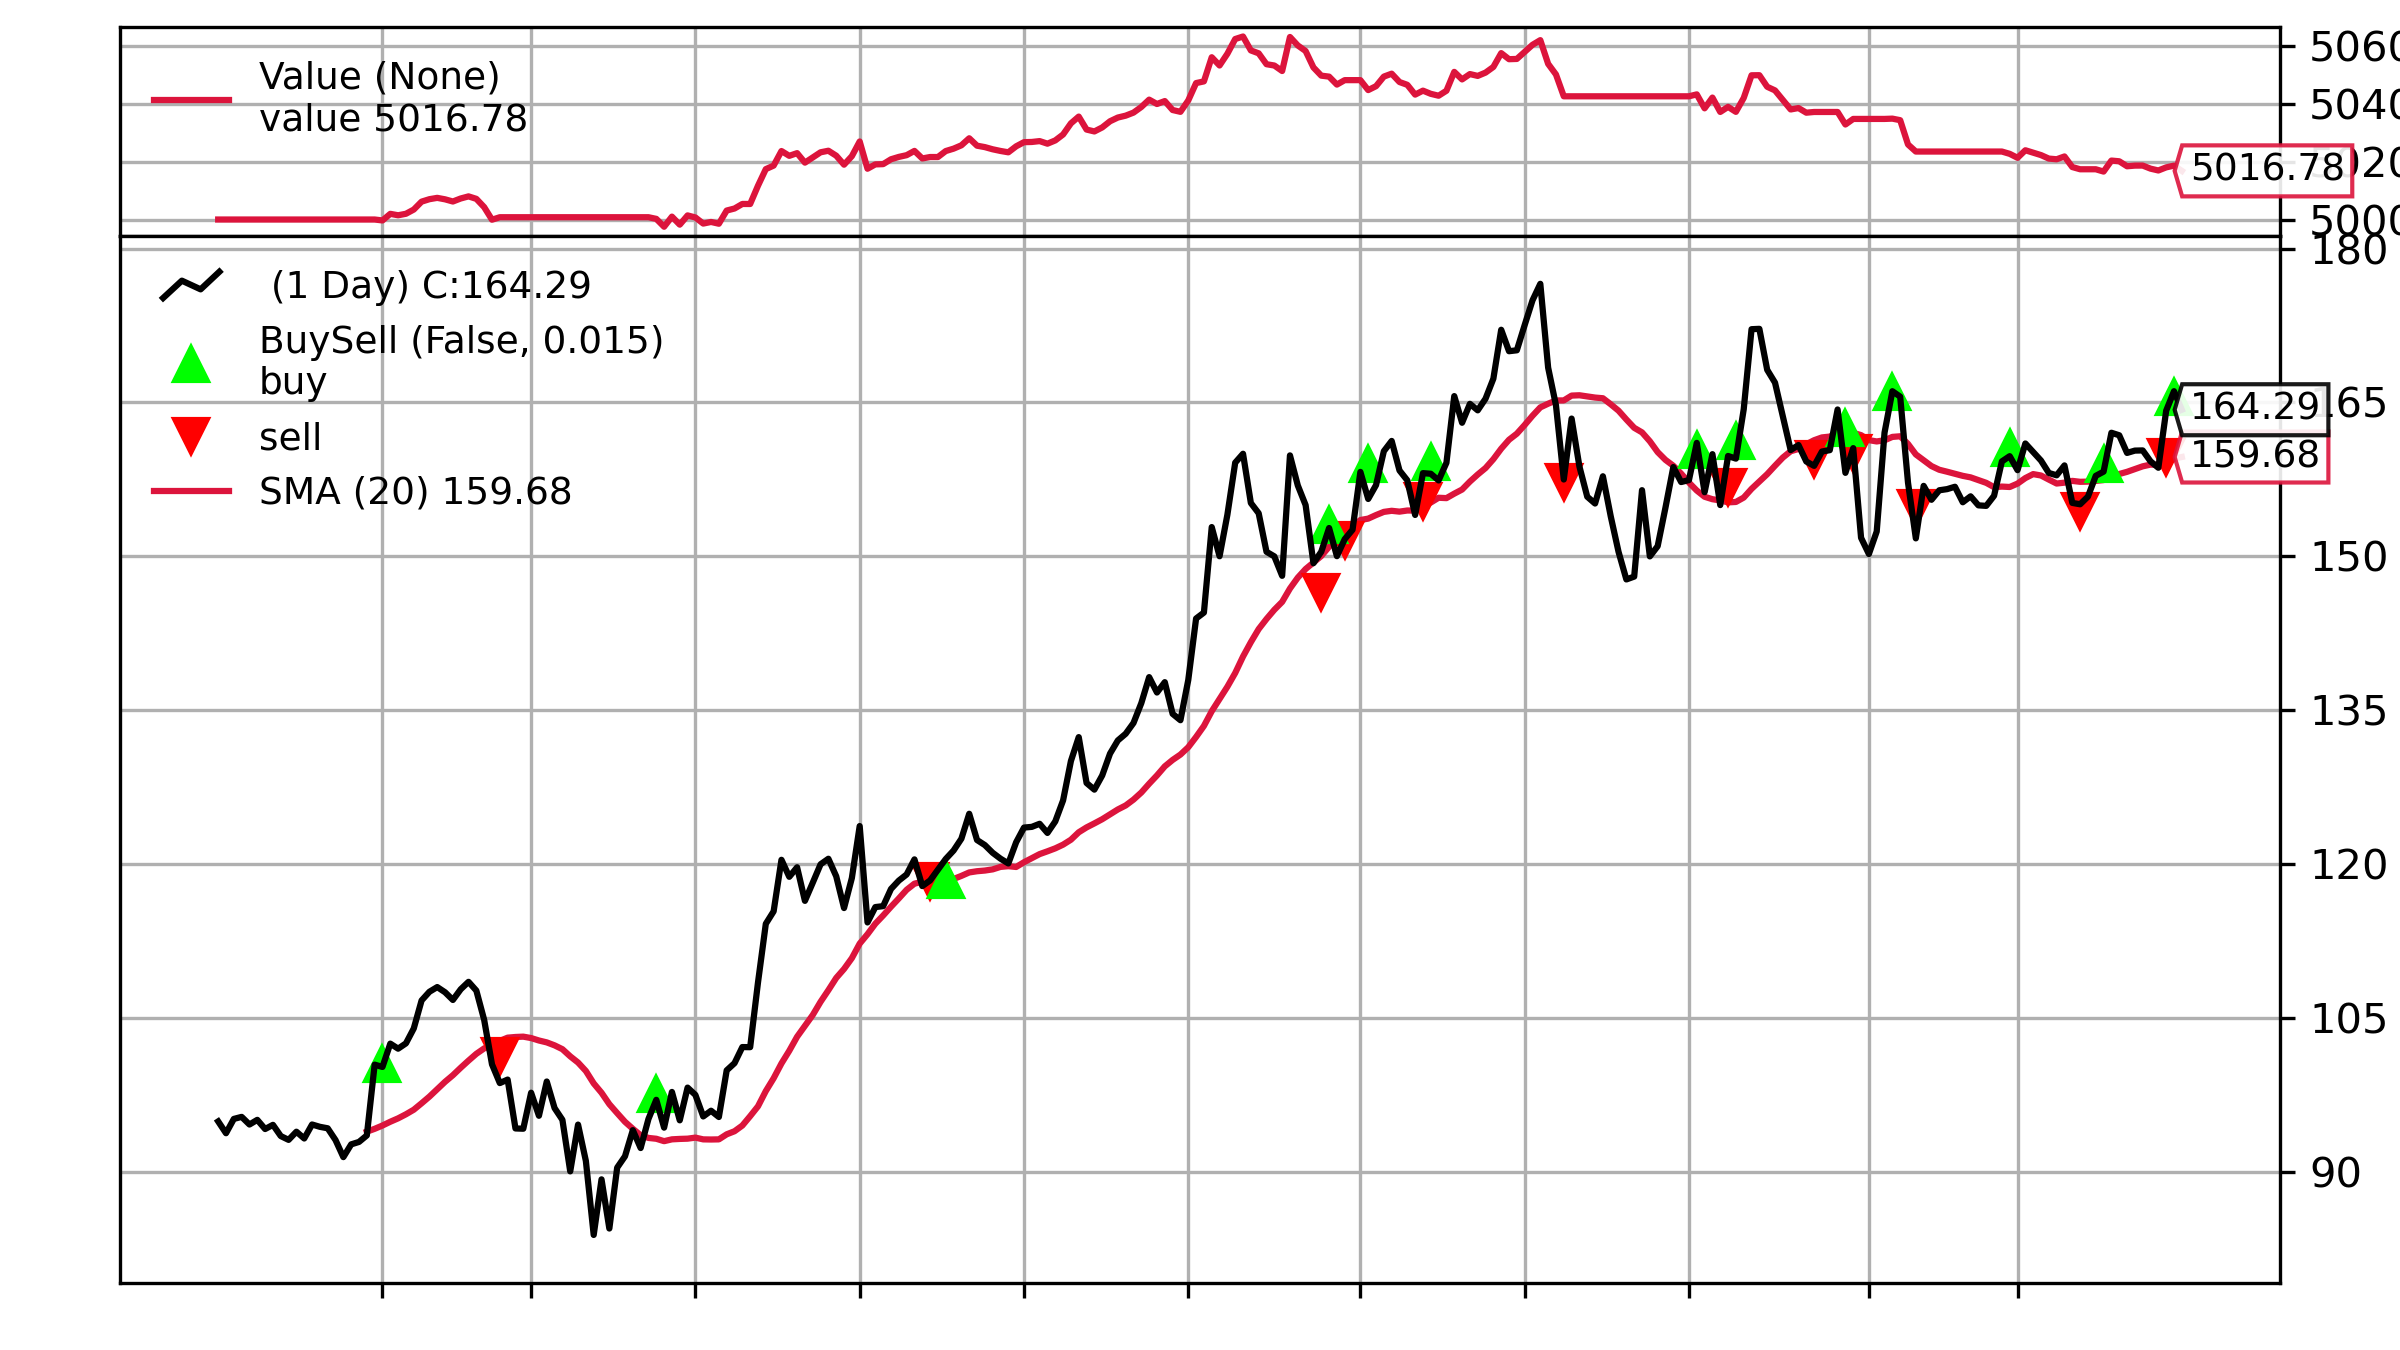

[[<Figure size 2400x1350 with 2 Axes>]]

In [52]:
cerebro.plot(iplot=True, volume=False)